In [1]:
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import tifffile
import yaml 
from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [12]:
from mushroom.registration.bigwarp import (
    read_bigwarp_warp_field, register_multiplex, register_visium, register_he, register_xenium, warp_pts, resize_and_warp)
from mushroom.data.multiplex import extract_ome_tiff, write_basic_ome_tiff, get_ome_tiff_channels, make_pseudo
from mushroom.data.visium import adata_from_visium, get_fullres_size
from mushroom.data.xenium import adata_from_xenium
from mushroom.visualization.utils import display_sections
import mushroom.utils as utils

In [13]:
run_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/'
bigwarp_dir = os.path.join(run_dir, 'registration')
registered_dir = os.path.join(run_dir, 'registered')
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [30]:
metadata = yaml.safe_load(open(os.path.join(bigwarp_dir, 'metadata.yaml')))
metadata

{'HT206B1': {'data': {'multiplex': {'HT206B1-U10': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U10__20230914.ome.tiff',
    'HT206B1-U13': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U13__20231002.ome.tiff',
    'HT206B1-U18': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U18__20230914.ome.tiff',
    'HT206B1-U2': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U2__20230914.ome.tiff',
    'HT206B1-U21': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U21__20231002.ome.tiff',
    'HT206B1-U5': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U5__20231002.ome.tiff'},
   'xenium': {'HT206B1-U1': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XET

In [31]:
fps = sorted(utils.listfiles(bigwarp_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s10_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s11_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s1_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s2_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s3_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s4_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s5_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s6_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s7_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xeniu

In [32]:
# only do S18-25943
keep = ['HT206B1', 'S18-25943', 'S18-9906']
metadata = {k:v for k, v in metadata.items() if k in keep}

In [33]:
case_to_ddfs = {}
for fp in fps:
    print(fp)
    case = fp.split('/')[-2]
    
    if case not in metadata:
        continue
    
    if case not in case_to_ddfs:
        case_to_ddfs[case] = {}
        
    scale = metadata[case]['scale']
    sid = re.findall(r'(s[0-9]+)_ddf.tif', fp)[0]
    ddf = read_bigwarp_warp_field(fp, scale)
    case_to_ddfs[case][sid] = ddf
    print(case, ddf.shape)
case_to_ddfs.keys() # c h w

/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s10_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s11_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s1_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s2_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s3_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s4_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s5_ddf.tif
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/

dict_keys(['HT206B1', 'S18-25943', 'S18-9906'])

In [12]:
adata = adata_from_xenium('/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011123__S18-25943-A7Us1_1__20231117__205842')
# ddf = case_to_ddfs['S18-25943']['s0']
# warped_adata = register_xenium(adata, ddf)
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 446471 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'transcripts', 'spatial'
    obsm: 'spatial'

In [14]:
adata2 = adata_from_xenium('/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011128__S18-25943-A7Us1_4__20231117__205843')
ddf2 = case_to_ddfs['S18-25943']['s1']
warped_adata2 = register_xenium(adata2, ddf2)
adata2

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 316047 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'transcripts', 'spatial'
    obsm: 'spatial'

(-419.3, 10763.3, -574.7, 12156.7)

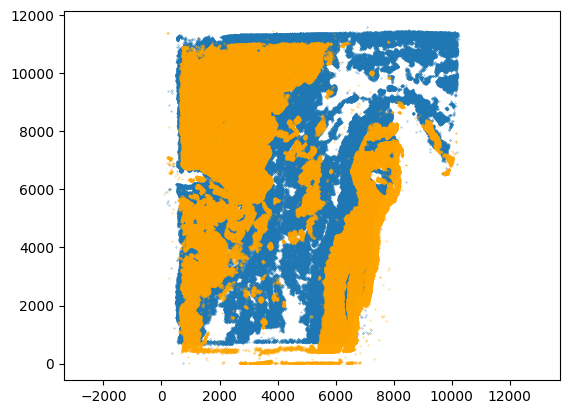

In [15]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=.05)
plt.scatter(adata2.obsm['spatial'][:, 0], adata2.obsm['spatial'][:, 1], s=.05, c='orange')
plt.axis('equal')

(-453.95000000000005, 10764.95, -548.45, 12155.45)

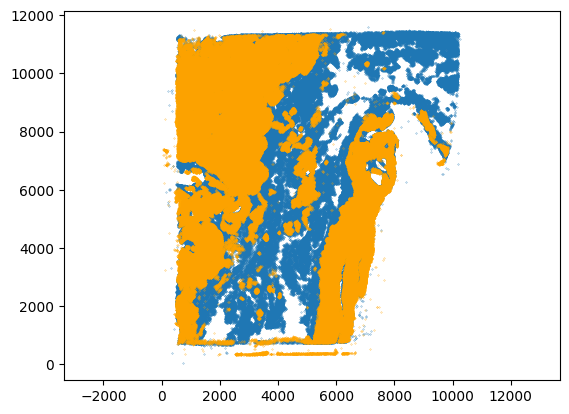

In [17]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=.05)
plt.scatter(warped_adata2.obsm['spatial'][:, 0], warped_adata2.obsm['spatial'][:, 1], s=.05, c='orange')
plt.axis('equal')

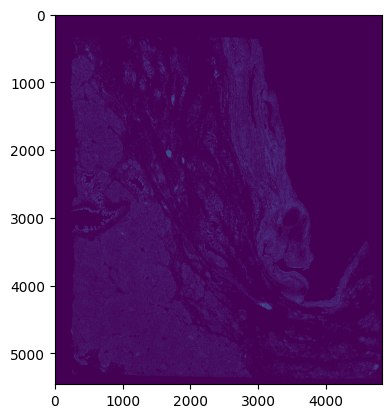

In [20]:
plt.imshow(adata.uns['spatial']['key']['images']['hires'])

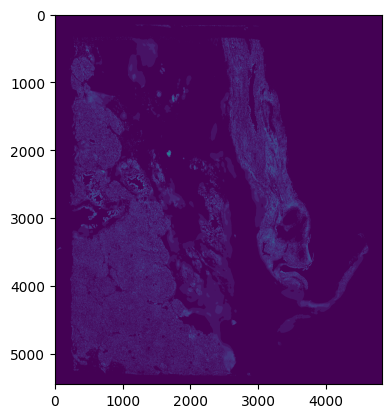

In [19]:
plt.imshow(warped_adata2.uns['spatial']['key']['images']['hires'])

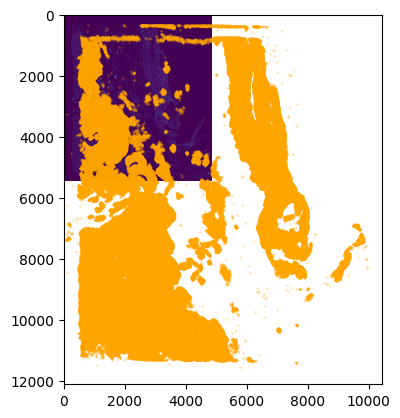

In [22]:
plt.imshow(adata.uns['spatial']['key']['images']['hires'])
plt.scatter(warped_adata2.obsm['spatial'][:, 0], warped_adata2.obsm['spatial'][:, 1], s=.05, c='orange')

In [18]:
for case, data in metadata.items():
    ppm = data['registered_pixels_per_micron']
    ids = data['ids']
    order = data['order']
    directory = os.path.join(registered_dir, case)
    Path(directory).mkdir(parents=True, exist_ok=True)

    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            print(dtype, sample, fp)
            sid = ids[order.index(sample)]
            ddf = case_to_ddfs[case].get(sid)

            if dtype == 'he':
                he = tifffile.imread(fp)
                he = rearrange(he, 'h w c -> c h w') # channel dim must be first
                if ddf is not None:
                    he = register_he(he, ddf)
                tifffile.imwrite(
                    os.path.join(directory, f'{sid}_he.tif'),
                    data=rearrange(he, 'c h w -> h w c'),
                    resolution=(ppm, ppm),
                    compression='LZW',
                    metadata={
                        'axes': 'YXC',
                        'unit': 'um',
                    }
                )
            elif dtype == 'visium':
                adata = adata_from_visium(fp)
                if ddf is not None:
                    adata = register_visium(
                        adata, ddf, target_pix_per_micron=ppm
                    )
                adata.write_h5ad(os.path.join(directory, f'{sid}_visium.h5ad'))
            elif dtype == 'xenium':
                adata = adata_from_xenium(fp)
                print(get_fullres_size(adata))
                if ddf is not None:
                    adata = register_xenium(
                        adata, ddf
                    )
                print(get_fullres_size(adata))
                
                adata.write_h5ad(os.path.join(directory, f'{sid}_xenium.h5ad'))
            elif dtype == 'multiplex':
                channels, data = extract_ome_tiff(fp, as_dict=False)
                if ddf is not None:
                    data = register_multiplex(data, ddf)
                print(data.shape)
                write_basic_ome_tiff(
                    os.path.join(directory, f'{sid}_multiplex.ome.tiff'),
                    data, channels, pix_per_micron=ppm
                )

multiplex S18-9906-U10 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff
(24, 8695, 8460)
multiplex S18-9906-U18 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff
(24, 8695, 8460)
multiplex S18-9906-U25 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff
(24, 8695, 8460)
multiplex S18-9906-U3 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff
(24, 8695, 8460)
xenium S18-9906-U17 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(9417, 8463)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(8693, 8459)
xenium S18-9906-U2 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(8697, 8461)
(8697, 8461)
xenium S18-9906-U24 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(9420, 9071)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(8693, 8459)
xenium S18-9906-U9 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(10138, 9073)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(8693, 8459)


In [34]:
fps = sorted(utils.listfiles(registered_dir, regex=r'\/s[0-9]+.*$'))
case_to_id_to_fp = {}
for fp in fps:
    case = fp.split('/')[-2]
    
    if case not in metadata:
        continue
        
    sid = re.sub(r'(s[0-9]+)_.*$', r'\1', fp.split('/')[-1])
    if case not in case_to_id_to_fp:
        case_to_id_to_fp[case] = {}
    
    case_to_id_to_fp[case][sid] = fp
case_to_id_to_fp

{'HT206B1': {'s0': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad',
  's10': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s10_multiplex.ome.tiff',
  's11': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s11_xenium.h5ad',
  's1': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s1_multiplex.ome.tiff',
  's2': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s2_multiplex.ome.tiff',
  's3': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad',
  's4': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s4_xenium.h5ad',
  's5': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s5_multiplex.ome.tiff',
  's6': '/diskmnt/Projects/Users/estorrs/mushroom/dat

In [35]:
registered_metadata = metadata.copy()
for case, data in registered_metadata.items():
    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            sid = data['ids'][data['order'].index(sample)]
            mapping[sample] = case_to_id_to_fp[case][sid]
registered_metadata

{'HT206B1': {'data': {'multiplex': {'HT206B1-U10': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s5_multiplex.ome.tiff',
    'HT206B1-U13': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s6_multiplex.ome.tiff',
    'HT206B1-U18': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s9_multiplex.ome.tiff',
    'HT206B1-U2': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s1_multiplex.ome.tiff',
    'HT206B1-U21': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s10_multiplex.ome.tiff',
    'HT206B1-U5': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s2_multiplex.ome.tiff'},
   'xenium': {'HT206B1-U1': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad',
    'HT206B1-U16': '/diskmnt/Projects/Users/estor

In [12]:
# yaml.safe_dump(registered_metadata, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [36]:
import sys
yaml.safe_dump(registered_metadata, sys.stdout)

HT206B1:
  data:
    multiplex:
      HT206B1-U10: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s5_multiplex.ome.tiff
      HT206B1-U13: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s6_multiplex.ome.tiff
      HT206B1-U18: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s9_multiplex.ome.tiff
      HT206B1-U2: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s1_multiplex.ome.tiff
      HT206B1-U21: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s10_multiplex.ome.tiff
      HT206B1-U5: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s2_multiplex.ome.tiff
    xenium:
      HT206B1-U1: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad
      HT206B1-U16: /diskmnt/Projects/Users/estorrs/mushroom/data/proj

In [37]:
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.data.multiplex as multiplex

In [64]:
# xfp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad'
xfp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s8_xenium.h5ad'
adata = sc.read_h5ad(xfp)
adata


AnnData object with n_obs × n_vars = 110489 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_original'

In [67]:
adata.obsm['spatial'].max(axis=0)

array([5712, 6525])

In [66]:
xenium.get_fullres_size(adata)

(6527, 6049)

In [58]:
fp = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s6_multiplex.ome.tiff'
channels, img = multiplex.extract_ome_tiff(fp, as_dict=False)

In [59]:
multiplex.pixels_per_micron(fp)

0.4705882352941177

In [60]:
img.shape

(38, 6530, 6050)

In [78]:
ppm = 0.4705882352941177

In [79]:
target_ppm = .01 # 100 microns per tile

In [80]:
tiling_size = int(ppm / target_ppm)
xen_img = xenium.to_multiplex(adata, tiling_size=tiling_size)
xen_img.shape

(139, 129, 477)

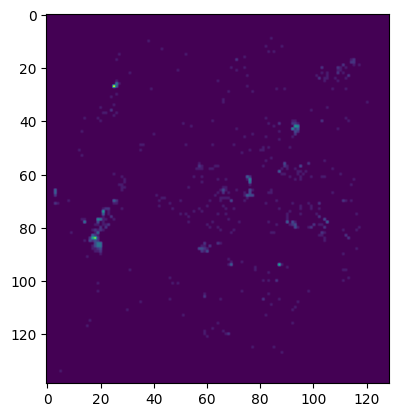

In [77]:
plt.imshow(xen_img[..., 0])

In [82]:
target_ppm / ppm

0.021249999999999998

In [83]:
mult_img = utils.rescale(img, scale=target_ppm / ppm, dim_order='c h w')
mult_img.shape

(38, 138, 128)